# Healthcare Lab (Qualitative Factors)

**Learning Objectives:**
  * Define and fit simple regression models with multiple factors, non-linear functional forms and qualitative factors.
  
  * Gain exposure to healthcare related DataSets

## Context of the dataset

### 1. The dataset is consisted of records corresponding to medical events.
### 2. Each medical event is uniquely identified by `MedicalClaim`.
### 3. A given medical event might involve several medical procedures.
### 4. Each medical procedure is uniquely identified by `ClaimItem`
### 5. A given medical procedure is characterized by `PrincipalDiagnosisDesc`,`PrincipalDiagnosis`,`RevenueCodeDesc`, `RevenueCode`, `TypeFlag` and `TotalExpenses`

### 6. Each medical procedure involves: `MemberName`,`MemberID`,`County`,`HospitalName`, `HospitalType`, `StartDate`,`EndDate`


## 1. Library Import

In [1]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt


In [2]:
warnings.simplefilter('ignore')

## 2. Data loading and DataFrame transformation



In [3]:
HealthCareDataSet=pd.read_csv("https://github.com/thousandoaks/Python4DS-I/raw/main/datasets/HealthcareDataset_PublicRelease.csv",sep=',',parse_dates=['StartDate','EndDate','BirthDate'])

In [4]:
HealthCareDataSet.head(3)

,Id,MemberName,MemberID,County,MedicalClaim,ClaimItem,HospitalName,HospitalType,StartDate,EndDate,PrincipalDiagnosisDesc,PrincipalDiagnosis,RevenueCodeDesc,RevenueCode,TypeFlag,BirthDate,TotalExpenses
0,634363,e659f3f4,6a380a28,6f943458,c1e3436737c77899,18,04b77561,HOSPITAL,2020-01-08,2020-01-08,Epigastric pain,R10.13,DRUGS REQUIRE SPECIFIC ID: DRUGS REQUIRING DET...,636.0,ER,1967-05-13,15.148
1,634364,e659f3f4,6a380a28,6f943458,c1e3436737c77899,21,04b77561,HOSPITAL,2020-01-08,2020-01-08,Epigastric pain,R10.13,DRUGS REQUIRE SPECIFIC ID: DRUGS REQUIRING DET...,636.0,ER,1967-05-13,3.073
2,634387,e659f3f4,6a380a28,6f943458,c1e3436737c77899,10,04b77561,HOSPITAL,2020-01-08,2020-01-08,Epigastric pain,R10.13,LABORATORY - CLINICAL DIAGNOSTIC: HEMATOLOGY,305.0,ER,1967-05-13,123.900


In [5]:
HealthCareDataSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52563 entries, 0 to 52562
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Id                      52563 non-null  int64         
 1   MemberName              52563 non-null  object        
 2   MemberID                52563 non-null  object        
 3   County                  52563 non-null  object        
 4   MedicalClaim            52563 non-null  object        
 5   ClaimItem               52563 non-null  int64         
 6   HospitalName            52563 non-null  object        
 7   HospitalType            52563 non-null  object        
 8   StartDate               52563 non-null  datetime64[ns]
 9   EndDate                 52563 non-null  datetime64[ns]
 10  PrincipalDiagnosisDesc  52563 non-null  object        
 11  PrincipalDiagnosis      52563 non-null  object        
 12  RevenueCodeDesc         52561 non-null  object

In [6]:
# We need to compute the variable: "AgeAtMedicalEvent"
HealthCareDataSet['AgeAtMedicalEvent']=(HealthCareDataSet['StartDate']-HealthCareDataSet['BirthDate'])
HealthCareDataSet['AgeAtMedicalEvent']=HealthCareDataSet['AgeAtMedicalEvent'].dt.total_seconds() / (365.25 * 24 * 60 * 60)

In [7]:
## We need to compute the duration of each Medical Treatment
HealthCareDataSet['MedicalTreatmentDuration']=(HealthCareDataSet['EndDate']-HealthCareDataSet['StartDate']).dt.days

In [8]:
HealthCareDataSet.groupby(['HospitalType','TypeFlag']).count()

Id  MemberName  MemberID  County  \
HospitalType             TypeFlag                                        
HOSPITAL                 ER        23978       23978     23978   23978   
                         INP       28506       28506     28506   28506   
HOSPITAL LONG TERM ACUTE INP          59          59        59      59   
REHABILITATION CENTER    INP          20          20        20      20   

                                   MedicalClaim  ClaimItem  HospitalName  \
HospitalType             TypeFlag                                          
HOSPITAL                 ER               23978      23978         23978   
                         INP              28506      28506         28506   
HOSPITAL LONG TERM ACUTE INP                 59         59            59   
REHABILITATION CENTER    INP                 20         20            20   

                                   StartDate  EndDate  PrincipalDiagnosisDesc  \
HospitalType             TypeFlag                                               
HOSPITAL                 ER            23978    23978                   23978   
                         INP           28506    28506                   28506   
HOSPITAL LONG TERM ACUTE INP              59       59                      59   
REHABILITATION CENTER    INP              20       20                      20   

                                   PrincipalDiagnosis  RevenueCodeDesc  \
HospitalType             TypeFlag                                        
HOSPITAL                 ER                     23978            23978   
                         INP                    28506            28504   
HOSPITAL LONG TERM ACUTE INP                       59               59   
REHABILITATION CENTER    INP                       20               20   

                                   RevenueCode  BirthDate  TotalExpenses  \
HospitalType             TypeFlag                                          
HOSPITAL                 ER              23978      23978          23978   
                         INP             28506      28506          28506   
HOSPITAL LONG TERM ACUTE INP                59         59             59   
REHABILITATION CENTER    INP                20         20             20   

                                   AgeAtMedicalEvent  MedicalTreatmentDuration  
HospitalType             TypeFlag                                               
HOSPITAL                 ER                    23978                     23978  
                         INP                   28506                     28506  
HOSPITAL LONG TERM ACUTE INP                      59                        59  
REHABILITATION CENTER    INP                      20                        20

### 3. Data Transformation
#### To keep the analysis as simple as possible we select only: (1) Observations from the top5 counties by medical events, (2) Observations satisfying the criteria: `HospitalType==HOSPITAL`

In [9]:
HealthCareDataSet.groupby(['County']).count().sort_values(by='Id',ascending=False).head(10)

,Id,MemberName,MemberID,MedicalClaim,ClaimItem,HospitalName,HospitalType,StartDate,EndDate,PrincipalDiagnosisDesc,PrincipalDiagnosis,RevenueCodeDesc,RevenueCode,TypeFlag,BirthDate,TotalExpenses,AgeAtMedicalEvent,MedicalTreatmentDuration
County,,,,,,,,,,,,,,,,,,
02af982d,23525,23525,23525,23525,23525,23525,23525,23525,23525,23525,23525,23525,23525,23525,23525,23525,23525,23525
425a37b2,9468,9468,9468,9468,9468,9468,9468,9468,9468,9468,9468,9468,9468,9468,9468,9468,9468,9468
fd218584,5349,5349,5349,5349,5349,5349,5349,5349,5349,5349,5349,5349,5349,5349,5349,5349,5349,5349
89e38653,3767,3767,3767,3767,3767,3767,3767,3767,3767,3767,3767,3767,3767,3767,3767,3767,3767,3767
b021dd12,2679,2679,2679,2679,2679,2679,2679,2679,2679,2679,2679,2679,2679,2679,2679,2679,2679,2679
6f943458,1849,1849,1849,1849,1849,1849,1849,1849,1849,1849,1849,1849,1849,1849,1849,1849,1849,1849
e6708950,1613,1613,1613,1613,1613,1613,1613,1613,1613,1613,1613,1611,1613,1613,1613,1613,1613,1613
ea48569b,1367,1367,1367,1367,1367,1367,1367,1367,1367,1367,1367,1367,1367,1367,1367,1367,1367,1367
7d9b432e,838,838,838,838,838,838,838,838,838,838,838,838,838,838,838,838,838,838


In [10]:
Top5Counties=HealthCareDataSet.groupby(['County']).count().sort_values(by='Id',ascending=False).head(5).index
Top5Counties

Index(['02af982d', '425a37b2', 'fd218584', '89e38653', 'b021dd12'], dtype='object', name='County')

In [11]:
HealthCareDataSetReduced=HealthCareDataSet[(HealthCareDataSet['County'].isin(Top5Counties))&(HealthCareDataSet['HospitalType']=='HOSPITAL')]
HealthCareDataSetReduced

,Id,MemberName,MemberID,County,MedicalClaim,ClaimItem,HospitalName,HospitalType,StartDate,EndDate,PrincipalDiagnosisDesc,PrincipalDiagnosis,RevenueCodeDesc,RevenueCode,TypeFlag,BirthDate,TotalExpenses,AgeAtMedicalEvent,MedicalTreatmentDuration
23,634408,0252e533,5476f764,b021dd12,e3b55a09106b403f,32,4a2b1885,HOSPITAL,2020-01-03,2020-01-06,Thrombosis due to vascula,T82.868A,DRUGS REQUIRE SPECIFIC ID: DRUGS REQUIRING DET...,636.0,ER,1935-01-31,51.555,84.922656,3
24,634409,0252e533,5476f764,b021dd12,e3b55a09106b403f,14,4a2b1885,HOSPITAL,2020-01-03,2020-01-06,Thrombosis due to vascula,T82.868A,LABORATORY - CLINICAL DIAGNOSTIC: CHEMISTRY,301.0,ER,1935-01-31,226.800,84.922656,3
25,634410,0252e533,5476f764,b021dd12,e3b55a09106b403f,13,4a2b1885,HOSPITAL,2020-01-03,2020-01-06,Thrombosis due to vascula,T82.868A,LABORATORY - CLINICAL DIAGNOSTIC,300.0,ER,1935-01-31,22.400,84.922656,3
26,634411,0252e533,5476f764,b021dd12,e3b55a09106b403f,17,4a2b1885,HOSPITAL,2020-01-03,2020-01-06,Thrombosis due to vascula,T82.868A,LABORATORY - CLINICAL DIAGNOSTIC: CHEMISTRY,301.0,ER,1935-01-31,14.700,84.922656,3
27,634412,511b5fce,a191c6bb,fd218584,d38d75f3f0c8ff1d,4,446442f4,HOSPITAL,2020-01-24,2020-01-24,Other chronic pain,G89.29,DRUGS REQUIRE SPECIFIC ID: DRUGS REQUIRING DET...,636.0,ER,1969-09-03,9.163,50.390144,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52558,741726,ff90a52f,4ed7db9f,425a37b2,90e8ae169cbba3bd,1,a9bf1474,HOSPITAL,2020-12-02,2020-12-09,Traumatic subarachnoid he,S06.6X0A,INTERMEDIATE ICU,206.0,INP,1940-04-13,2436.000,80.637919,7
52559,741733,f90fcde2,c88e4212,425a37b2,8b6a8d2720d16e97,7,a9bf1474,HOSPITAL,2020-12-18,2020-12-22,Iron deficiency anemia se,D50.0,LABORATORY - CLINICAL DIAGNOSTIC: HEMATOLOGY,305.0,INP,1950-09-15,2075.500,70.258727,4
52560,741734,f90fcde2,c88e4212,425a37b2,8b6a8d2720d16e97,8,a9bf1474,HOSPITAL,2020-12-18,2020-12-22,Iron deficiency anemia se,D50.0,RADIOLOGY - DIAGNOSTIC: CHEST X-RAY,324.0,INP,1950-09-15,865.900,70.258727,4
52561,741735,f90fcde2,c88e4212,425a37b2,8b6a8d2720d16e97,12,a9bf1474,HOSPITAL,2020-12-18,2020-12-22,Iron deficiency anemia se,D50.0,EKG/ECG,730.0,INP,1950-09-15,665.000,70.258727,4


### 4. Impact of Age, Medical Treatment Duration, and Type of Medical Treatment on Total Costs.

#### To study this we fit a model regressing these variables on the log of 'TotalExpenses' (Log-Level model)

In [12]:
HealthCareDataSetReducedGroupedByMedicalClaim=HealthCareDataSetReduced.groupby(['MedicalClaim','TypeFlag']).agg({'TotalExpenses':'sum','MedicalTreatmentDuration':'mean','AgeAtMedicalEvent':'mean'}).reset_index()
HealthCareDataSetReducedGroupedByMedicalClaim.rename(columns={'TotalExpenses':'TotalExpensesPerClaim'},inplace=True)
HealthCareDataSetReducedGroupedByMedicalClaim.head(10)

,MedicalClaim,TypeFlag,TotalExpensesPerClaim,MedicalTreatmentDuration,AgeAtMedicalEvent
0,0012a8eb3c2be5f5,ER,4668.692,0.0,64.232717
1,002fd7d73d8060f1,INP,53501.259,6.0,74.863792
2,003886fc8ec986d4,ER,17115.714,0.0,64.380561
3,004fa1cd47f65193,ER,3672.361,0.0,68.944559
4,005edafb00d0f6eb,ER,2548.700,0.0,73.338809
5,00969aeec9d6d34d,INP,71096.228,6.0,76.865161
6,00d6e1292eeddde0,ER,5915.021,0.0,73.210130
7,0100acd166512fa8,INP,34893.131,4.0,73.798768
8,0105afbd4371e396,ER,17947.720,0.0,73.500342
9,0113b5a41993f224,ER,14887.600,0.0,78.677618


#### 4.1. Model Fit
##### We start by fitting a log-level model that includes quantitative factors such as `MedicalTreatmentDuration` and `AgeAtMedicalEvent` as well as a dummy variable to control for `TypeFlag`
##### We specify the log of  TotalExpensesPerClaim as the response variable.

In [13]:

firstModel = smf.ols(formula='np.log(TotalExpensesPerClaim) ~ AgeAtMedicalEvent+MedicalTreatmentDuration+TypeFlag', data=HealthCareDataSetReducedGroupedByMedicalClaim)

In [14]:
#We fit the model
firstModelResults = firstModel.fit()

In [15]:
b = firstModelResults.params
print(f'b: \n{b}\n')

b: 
Intercept                   8.400806
TypeFlag[T.INP]             1.613006
AgeAtMedicalEvent           0.007379
MedicalTreatmentDuration    0.077733
dtype: float64



In [16]:
firstModelResults.rsquared

0.5870476892161929

#### 4.2. Model Interpretation
##### Based on the previous we have fitted the following model:

$ log(TotalExpensesPerClaim)=8.4+1.61*TypeFlag_{INP}+0.0073*AgeAtMedicalEvent+0.077*MedicalTreatmentDuration+u $

\\

#### The factor `TypeFlag` is a binary variable which takes the value Zero if the observation corresponds to an Emergency Room Service Event and the value One of the observation correspond to an Inpatient Event. This means that the value of reference is the Emergency Room Category. This information allows us to interpret the value of the coefficient (1.613): it means that the cost difference between Inpatient Medical Events and Emergency Room Events is 100*1.613=161%.
\\

#### The factor `AgeAtMedicalEvent` is a regular quantitative factor, given that we are fitting a log-level model the value of the coefficient (0.007379) means that a unit increment of `AgeAtMedicalEvent` increases `TotalExpensesPerClaim` by 100*0.0073=0.73%.
\\

#### The factor `MedicalTreatmentDuration` is a regular quantitative factor, given that we are fitting a log-level model the value of the coefficient (0.077) means that a unit increment of `MedicalTreatmentDuration` increases `TotalExpensesPerClaim` by 100*0.077=7.7%.

#### The value of R-squared is 0.58, this means that our model explains 58% of the total variance.


#### 4.2. t-Test
##### We perform a t-Test for each independent variable under consideration. The good news is that the library statsmodel does it for us.


In [17]:
firstModelResults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     np.log(TotalExpensesPerClaim)   R-squared:                       0.587
Model:                                       OLS   Adj. R-squared:                  0.587
Method:                            Least Squares   F-statistic:                     1351.
Date:                           Fri, 02 Aug 2024   Prob (F-statistic):               0.00
Time:                                   09:29:12   Log-Likelihood:                -3729.7
No. Observations:                           2856   AIC:                             7467.
Df Residuals:                               2852   BIC:                             7491.
Df Model:                                      3                                         
Covariance Type:                       nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    8.4008      0.094     88.984      0.000       8.216       8.586
TypeFlag[T.INP]              1.6130      0.040     40.511      0.000       1.535       1.691
AgeAtMedicalEvent            0.0074      0.001      5.577      0.000       0.005       0.010
MedicalTreatmentDuration     0.0777      0.004     18.849      0.000       0.070       0.086
==============================================================================
Omnibus:                      215.010   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              397.835
Skew:                          -0.531   Prob(JB):                     4.09e-87
Kurtosis:                       4.489   Cond. No.                         408.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Based on the previous table we conclude that: all the p-values are close to Zero, this means that all factors considered are statistically significant.



#### 4.3 F-Test
##### We perform a F-Test for the whole model. The good news is that the library statsmodel does it for us.

In [18]:
firstModelResults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     np.log(TotalExpensesPerClaim)   R-squared:                       0.587
Model:                                       OLS   Adj. R-squared:                  0.587
Method:                            Least Squares   F-statistic:                     1351.
Date:                           Fri, 02 Aug 2024   Prob (F-statistic):               0.00
Time:                                   09:29:12   Log-Likelihood:                -3729.7
No. Observations:                           2856   AIC:                             7467.
Df Residuals:                               2852   BIC:                             7491.
Df Model:                                      3                                         
Covariance Type:                       nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    8.4008      0.094     88.984      0.000       8.216       8.586
TypeFlag[T.INP]              1.6130      0.040     40.511      0.000       1.535       1.691
AgeAtMedicalEvent            0.0074      0.001      5.577      0.000       0.005       0.010
MedicalTreatmentDuration     0.0777      0.004     18.849      0.000       0.070       0.086
==============================================================================
Omnibus:                      215.010   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              397.835
Skew:                          -0.531   Prob(JB):                     4.09e-87
Kurtosis:                       4.489   Cond. No.                         408.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

####  Given the results of the F-statistic (1351) and its associated p-value (0.000) as shown in the previous table we conclude that the model is statistically significant (not all Beta coefficients are ZERO at the same time)

### 5. Impact of Age, Medical Treatment Duration,County and Type of Medical Treatment on Total Costs.

#### To study this we fit a model regressing these variables on the log of 'TotalExpenses' (Log-Level model)

In [19]:
HealthCareDataSetReducedGroupedByMedicalClaim=HealthCareDataSetReduced.groupby(['MedicalClaim','TypeFlag','County']).agg({'TotalExpenses':'sum','MedicalTreatmentDuration':'mean','AgeAtMedicalEvent':'mean'}).reset_index()
HealthCareDataSetReducedGroupedByMedicalClaim.rename(columns={'TotalExpenses':'TotalExpensesPerClaim'},inplace=True)
HealthCareDataSetReducedGroupedByMedicalClaim.head(10)

,MedicalClaim,TypeFlag,County,TotalExpensesPerClaim,MedicalTreatmentDuration,AgeAtMedicalEvent
0,0012a8eb3c2be5f5,ER,fd218584,4668.692,0.0,64.232717
1,002fd7d73d8060f1,INP,b021dd12,53501.259,6.0,74.863792
2,003886fc8ec986d4,ER,fd218584,17115.714,0.0,64.380561
3,004fa1cd47f65193,ER,02af982d,3672.361,0.0,68.944559
4,005edafb00d0f6eb,ER,425a37b2,2548.700,0.0,73.338809
5,00969aeec9d6d34d,INP,425a37b2,71096.228,6.0,76.865161
6,00d6e1292eeddde0,ER,02af982d,5915.021,0.0,73.210130
7,0100acd166512fa8,INP,02af982d,34893.131,4.0,73.798768
8,0105afbd4371e396,ER,02af982d,17947.720,0.0,73.500342
9,0113b5a41993f224,ER,425a37b2,14887.600,0.0,78.677618


In [20]:
HealthCareDataSetReducedGroupedByMedicalClaim.groupby('County').count().index

Index(['02af982d', '425a37b2', '89e38653', 'b021dd12', 'fd218584'], dtype='object', name='County')

#### 5.1. Model Fit
##### We start by fitting a log-level model that includes quantitative factors such as `MedicalTreatmentDuration` and `AgeAtMedicalEvent` as well as a dummy variable to control for `TypeFlag` and `County`
##### We specify the log of  TotalExpensesPerClaim as the response variable.

In [21]:
secondModel = smf.ols(formula='np.log(TotalExpensesPerClaim) ~ AgeAtMedicalEvent+MedicalTreatmentDuration+TypeFlag+County', data=HealthCareDataSetReducedGroupedByMedicalClaim)

In [22]:
#We fit the model
secondModelResults = secondModel.fit()

In [23]:
b = secondModelResults.params
print(f'b: \n{b}\n')

b: 
Intercept                   8.317128
TypeFlag[T.INP]             1.598609
County[T.425a37b2]         -0.146459
County[T.89e38653]          0.017155
County[T.b021dd12]          0.052512
County[T.fd218584]          0.271376
AgeAtMedicalEvent           0.008544
MedicalTreatmentDuration    0.078473
dtype: float64



In [24]:
secondModelResults.rsquared

0.5935394064198362

#### 5.2. Model Interpretation
##### Based on the previous we have fitted the following model:

$ log(TotalExpensesPerClaim)=8.31+1.59*TypeFlag_{INP}+0.0085*AgeAtMedicalEvent+0.078*MedicalTreatmentDuration-0.14*County_{425a37b2}+0.017*County_{89e38653}+0.052*County_{b021dd12}+0.2713+0.27*County_{fd218584}+u $

\\

#### The factor `TypeFlag` is a binary variable which takes the value Zero if the observation corresponds to an Emergency Room Service Event and the value One of the observation correspond to an Inpatient Event. This means that the value of reference is the Emergency Room Category. This information allows us to interpret the value of the coefficient (1.59): it means that the cost difference between Inpatient Medical Events and Emergency Room Events is 100*1.59=159%.
\\

#### The factor `AgeAtMedicalEvent` is a regular quantitative factor, given that we are fitting a log-level model the value of the coefficient (0.0085) means that a unit increment of `AgeAtMedicalEvent` increases `TotalExpensesPerClaim` by 100*0.0085=0.85%.
\\

#### The factor `MedicalTreatmentDuration` is a regular quantitative factor, given that we are fitting a log-level model the value of the coefficient (0.078) means that a unit increment of `MedicalTreatmentDuration` increases `TotalExpensesPerClaim` by 100*0.078=7.8%.


#### We have a set of dummies to control for the five catetories of counties we have in our dataset ('02af982d', '425a37b2', '89e38653', 'b021dd12', 'fd218584'). To prevent multicollinearity the software selects a category as the reference, in this case it is the county named: '02af982d'. This information allows us to interpret the value of the county coefficients:

1. The coefficient associated with county named `425a37b2` (-0.14) implies that the cost difference between the county `425a37b2` and the county of reference `02af982d` is -14%. This means that `TotalExpensesPerClaim` of the county `425a37b2` are 14% lower than those of the county of reference `02af982d`.

2. The coefficient associated with county named `89e38653` (0.017) implies that the cost difference between the county `89e38653` and the county of reference `02af982d` is 1.7%. This means that `TotalExpensesPerClaim` of the county `89e38653` are 1.7% higher than those of the county of reference `02af982d`.

3. The coefficient associated with county named `b021dd12` (0.05) implies that the cost difference between the county `b021dd12` and the county of reference `02af982d` is 5%. This means that `TotalExpensesPerClaim` of the county `b021dd12` are 5% higher than those of the county of reference `02af982d`.

4. The coefficient associated with county named `fd218584` (0.27) implies that the cost difference between the county `fd218584` and the county of reference `02af982d` is 27%. This means that `TotalExpensesPerClaim` of the county `fd218584` are 27% higher than those of the county of reference `02af982d`.



#### The value of R-squared is 0.59, this means that our model explains 59% of the total variance.

#### 5.3. t-Test
##### We perform a t-Test for each independent variable under consideration. The good news is that the library statsmodel does it for us.


In [25]:
secondModelResults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     np.log(TotalExpensesPerClaim)   R-squared:                       0.594
Model:                                       OLS   Adj. R-squared:                  0.593
Method:                            Least Squares   F-statistic:                     594.1
Date:                           Fri, 02 Aug 2024   Prob (F-statistic):               0.00
Time:                                   09:29:12   Log-Likelihood:                -3707.0
No. Observations:                           2856   AIC:                             7430.
Df Residuals:                               2848   BIC:                             7478.
Df Model:                                      7                                         
Covariance Type:                       nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    8.3171      0.098     84.731      0.000       8.125       8.510
TypeFlag[T.INP]              1.5986      0.040     40.274      0.000       1.521       1.676
County[T.425a37b2]          -0.1465      0.043     -3.370      0.001      -0.232      -0.061
County[T.89e38653]           0.0172      0.061      0.279      0.780      -0.103       0.138
County[T.b021dd12]           0.0525      0.077      0.686      0.493      -0.098       0.203
County[T.fd218584]           0.2714      0.055      4.977      0.000       0.164       0.378
AgeAtMedicalEvent            0.0085      0.001      6.376      0.000       0.006       0.011
MedicalTreatmentDuration     0.0785      0.004     19.134      0.000       0.070       0.087
==============================================================================
Omnibus:                      211.119   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              392.884
Skew:                          -0.521   Prob(JB):                     4.86e-86
Kurtosis:                       4.489   Cond. No.                         449.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Based on the previous table we conclude that: the p-values for the following counties are not close to zero: `89e38653`,`b021dd12`. Therefore the coefficients associated with these two counties (0.0172 and 0.0525 respectively) are NOT statistically significant.

#### 5.4 F-Test
##### We perform a F-Test for the whole model. The good news is that the library statsmodel does it for us.

In [26]:
secondModelResults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     np.log(TotalExpensesPerClaim)   R-squared:                       0.594
Model:                                       OLS   Adj. R-squared:                  0.593
Method:                            Least Squares   F-statistic:                     594.1
Date:                           Fri, 02 Aug 2024   Prob (F-statistic):               0.00
Time:                                   09:29:13   Log-Likelihood:                -3707.0
No. Observations:                           2856   AIC:                             7430.
Df Residuals:                               2848   BIC:                             7478.
Df Model:                                      7                                         
Covariance Type:                       nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    8.3171      0.098     84.731      0.000       8.125       8.510
TypeFlag[T.INP]              1.5986      0.040     40.274      0.000       1.521       1.676
County[T.425a37b2]          -0.1465      0.043     -3.370      0.001      -0.232      -0.061
County[T.89e38653]           0.0172      0.061      0.279      0.780      -0.103       0.138
County[T.b021dd12]           0.0525      0.077      0.686      0.493      -0.098       0.203
County[T.fd218584]           0.2714      0.055      4.977      0.000       0.164       0.378
AgeAtMedicalEvent            0.0085      0.001      6.376      0.000       0.006       0.011
MedicalTreatmentDuration     0.0785      0.004     19.134      0.000       0.070       0.087
==============================================================================
Omnibus:                      211.119   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              392.884
Skew:                          -0.521   Prob(JB):                     4.86e-86
Kurtosis:                       4.489   Cond. No.                         449.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

####  Given the results of the F-statistic (594.1) and its associated p-value (0.000) as shown in the previous table we conclude that the model is statistically significant (not all Beta coefficients are ZERO at the same time)

### 6. Impact of Age, Medical Treatment Duration,County and Type of Medical Treatment on Total Costs.

#### To study this we fit a model regressing these variables on the log of 'TotalExpenses' (Log-Level model), this time we add quadratic effects

In [27]:
ealthCareDataSetReducedGroupedByMedicalClaim=HealthCareDataSetReduced.groupby(['MedicalClaim','TypeFlag','County']).agg({'TotalExpenses':'sum','MedicalTreatmentDuration':'mean','AgeAtMedicalEvent':'mean'}).reset_index()
HealthCareDataSetReducedGroupedByMedicalClaim.rename(columns={'TotalExpenses':'TotalExpensesPerClaim'},inplace=True)
HealthCareDataSetReducedGroupedByMedicalClaim.head(10)

,MedicalClaim,TypeFlag,County,TotalExpensesPerClaim,MedicalTreatmentDuration,AgeAtMedicalEvent
0,0012a8eb3c2be5f5,ER,fd218584,4668.692,0.0,64.232717
1,002fd7d73d8060f1,INP,b021dd12,53501.259,6.0,74.863792
2,003886fc8ec986d4,ER,fd218584,17115.714,0.0,64.380561
3,004fa1cd47f65193,ER,02af982d,3672.361,0.0,68.944559
4,005edafb00d0f6eb,ER,425a37b2,2548.700,0.0,73.338809
5,00969aeec9d6d34d,INP,425a37b2,71096.228,6.0,76.865161
6,00d6e1292eeddde0,ER,02af982d,5915.021,0.0,73.210130
7,0100acd166512fa8,INP,02af982d,34893.131,4.0,73.798768
8,0105afbd4371e396,ER,02af982d,17947.720,0.0,73.500342
9,0113b5a41993f224,ER,425a37b2,14887.600,0.0,78.677618


#### 6.1. Model Fit
##### We start by fitting a log-level model that includes quantitative factors such as `MedicalTreatmentDuration` and `AgeAtMedicalEvent` as well as a dummy variable to control for `TypeFlag` and `County`
##### We specify the log of  TotalExpensesPerClaim as the response variable.

#### We add a quadratic effect to the factors `AgeAtMedicalEvent` and `MedicalTreatmentDuration`

In [28]:
thirdModel = smf.ols(formula='np.log(TotalExpensesPerClaim) ~ AgeAtMedicalEvent+MedicalTreatmentDuration+TypeFlag+County++np.power(MedicalTreatmentDuration,2)++np.power(AgeAtMedicalEvent,2)', data=HealthCareDataSetReducedGroupedByMedicalClaim)

In [29]:
#We fit the model
thirdModelResults = thirdModel.fit()

In [30]:
thirdModelResults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     np.log(TotalExpensesPerClaim)   R-squared:                       0.612
Model:                                       OLS   Adj. R-squared:                  0.611
Method:                            Least Squares   F-statistic:                     498.3
Date:                           Fri, 02 Aug 2024   Prob (F-statistic):               0.00
Time:                                   09:29:13   Log-Likelihood:                -3641.4
No. Observations:                           2856   AIC:                             7303.
Df Residuals:                               2846   BIC:                             7362.
Df Model:                                      9                                         
Covariance Type:                       nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 7.8456      0.282     27.823      0.000       7.293       8.399
TypeFlag[T.INP]                           1.3794      0.043     31.887      0.000       1.295       1.464
County[T.425a37b2]                       -0.1431      0.042     -3.368      0.001      -0.226      -0.060
County[T.89e38653]                        0.0160      0.060      0.266      0.790      -0.102       0.134
County[T.b021dd12]                        0.0653      0.075      0.869      0.385      -0.082       0.213
County[T.fd218584]                        0.2590      0.053      4.859      0.000       0.154       0.364
AgeAtMedicalEvent                         0.0244      0.009      2.825      0.005       0.007       0.041
MedicalTreatmentDuration                  0.1331      0.006     21.223      0.000       0.121       0.145
np.power(MedicalTreatmentDuration, 2)    -0.0009   7.76e-05    -11.382      0.000      -0.001      -0.001
np.power(AgeAtMedicalEvent, 2)           -0.0001   6.54e-05     -1.968      0.049      -0.000   -4.44e-07
==============================================================================
Omnibus:                      109.840   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.703
Skew:                          -0.420   Prob(JB):                     1.25e-30
Kurtosis:                       3.672   Cond. No.                     9.52e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.52e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 6.2. Model Interpretation
##### Based on the previous we have fitted the following model:

$ log(TotalExpensesPerClaim)=7.84+1.37*TypeFlag_{INP}+0.0244*AgeAtMedicalEvent+0.1331*MedicalTreatmentDuration-0.14*County_{425a37b2}+0.016*County_{89e38653}+0.065*County_{b021dd12}+0.2713+0.25*County_{fd218584}-0.0009*MedicalTreatmentDuration^2-0.0001*AgeAtMedicalEvent^2+u $

\
#### the model is able to explain 61% of the variance (R-squared=0.61).
#### The F-test of overall significance (498.3, p-value=0.00) indicates that the model is "valid" (statistically significant).

#### We observe that the quadratic effects $MedicalTreatmentDuration^2$ and $AgeAtMedicalEvent^2$ are statistically significant (p-values: 0.000 and 0.0049 respectively)

#### 6.3. Model visualization

In [31]:
TotalExpenses_logscale_Inpatients_60yearOld_ReferenceCounty=[7.84+1.37+0.0244*60+0.1331*duration-0.0009*duration*duration-0.0001*60*60 for duration in range(0,50,1)]

TotalExpenses_logscale_Inpatients_60yearOld_425a37b2County=[7.84+1.37+0.0244*60+0.1331*duration-0.14-0.0009*duration*duration-0.0001*60*60 for duration in range(0,50,1)]


In [32]:
TotalExpenses_logscale_Inpatients_60yearOld=pd.DataFrame([TotalExpenses_logscale_Inpatients_60yearOld_ReferenceCounty,TotalExpenses_logscale_Inpatients_60yearOld_425a37b2County]).T
TotalExpenses_logscale_Inpatients_60yearOld.rename(columns={0: 'Reference County_02af982d', 1: 'County_425a37b2'}, inplace=True)

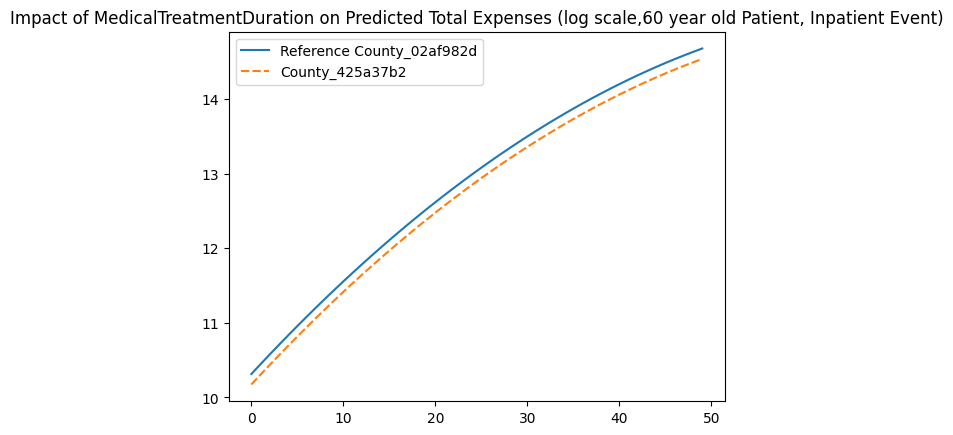

In [33]:
sns.lineplot( TotalExpenses_logscale_Inpatients_60yearOld).set_title('Impact of MedicalTreatmentDuration on Predicted Total Expenses (log scale,60 year old Patient, Inpatient Event)');